介绍如何在pytorch环境下，使用DeepFool算法攻击基于ImageNet数据集预训练的alexnet模型。

Jupyter notebook中使用Anaconda中的环境需要单独配置，默认情况下使用的是系统默认的Python环境，以使用advbox环境为例。
首先在默认系统环境下执行以下命令，安装ipykernel。

    conda install ipykernel
    conda install -n advbox ipykernel

在advbox环境下激活，这样启动后就可以在界面上看到advbox了。

    python -m ipykernel install --user --name advbox --display-name advbox 


In [1]:
#打开调试日志
import logging
logging.basicConfig(level=logging.INFO,format="%(filename)s[line:%(lineno)d] %(levelname)s %(message)s")
logger=logging.getLogger(__name__)

import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torchvision import models
from advbox.adversary import Adversary
from advbox.attacks.deepfool import DeepFoolAttack
from advbox.models.pytorch import PytorchModel
import numpy as np
import cv2
from tools import show_images_diff

In [2]:
#定义被攻击的图片
image_path="tutorials/cropped_panda.jpg"

In [3]:
# Define what device we are using
logging.info("CUDA Available: {}".format(torch.cuda.is_available()))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#cv2默认读取格式为bgr bgr -> rgb   
orig = cv2.imread(image_path)[..., ::-1]
#转换成224*224
orig = cv2.resize(orig, (224, 224))
adv=None
img = orig.copy().astype(np.float32)

#图像数据标准化
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std

#pytorch中图像格式为CHW  
#[224,224,3]->[3,224,224]
img = img.transpose(2, 0, 1)

img = Variable(torch.from_numpy(img).to(device).float().unsqueeze(0)).cpu().numpy()


# Initialize the network
#Alexnet
model = models.alexnet(pretrained=True).to(device).eval()

#print(model)

#设置为不保存梯度值 自然也无法修改
for param in model.parameters():
    param.requires_grad = False

# advbox demo
m = PytorchModel(
    model, None,(-3, 3),
    channel_axis=1)

#实例化DeepFool 
attack = DeepFoolAttack(m)
attack_config = {"iterations": 100, "overshoot": 0.02}

inputs=img
labels = None

print(inputs.shape)

adversary = Adversary(inputs, labels)

#定向攻击
tlabel = 538
adversary.set_target(is_targeted_attack=True, target_label=tlabel)


adversary = attack(adversary, **attack_config)

if adversary.is_successful():
    print(
        'attack success, adversarial_label=%d'
        % (adversary.adversarial_label))

    adv=adversary.adversarial_example[0]

else:
    print('attack failed')


print("deepfool attack done")

<ipython-input-3-688f3b2a4d4b>[line:2] INFO CUDA Available: False
pytorch.py[line:66] INFO Finish PytorchModel init
base.py[line:87] INFO adversary:
         original_label: 388
         target_label: 538
         is_targeted_attack: True
deepfool.py[line:54] INFO min_=-3, max_=3
deepfool.py[line:73] INFO select label:538


cpu
(1, 3, 224, 224)


deepfool.py[line:121] INFO iteration=0, f[pre_label]=6.33254623413, f[target_label]=-1.91577374935, f[adv_label]=8.76095581055, pre_label=388, adv_label=266
deepfool.py[line:121] INFO iteration=1, f[pre_label]=2.89678573608, f[target_label]=-0.87459141016, f[adv_label]=9.90505599976, pre_label=388, adv_label=153
deepfool.py[line:121] INFO iteration=2, f[pre_label]=0.944459617138, f[target_label]=-0.136466905475, f[adv_label]=10.4868774414, pre_label=388, adv_label=153
deepfool.py[line:121] INFO iteration=3, f[pre_label]=0.350003749132, f[target_label]=0.192997470498, f[adv_label]=10.7110366821, pre_label=388, adv_label=153
deepfool.py[line:121] INFO iteration=4, f[pre_label]=0.254496186972, f[target_label]=0.256794452667, f[adv_label]=10.7316360474, pre_label=388, adv_label=153
deepfool.py[line:121] INFO iteration=5, f[pre_label]=0.253140777349, f[target_label]=0.257781863213, f[adv_label]=10.7320013046, pre_label=388, adv_label=153
deepfool.py[line:121] INFO iteration=6, f[pre_label]=

attack success, adversarial_label=538
deepfool attack done


In [4]:
#格式转换
adv = adv.transpose(1, 2, 0)
adv = (adv * std) + mean
adv = adv * 256.0
adv = np.clip(adv, 0, 255).astype(np.uint8)


l0=123793 l2=64327.3090996


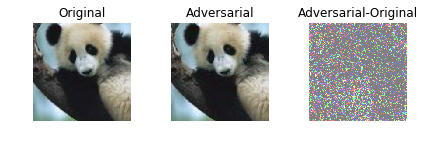

In [5]:
#显示原始图片  抵抗样本 以及两张图之间的差异  其中灰色代表没有差异的像素点
show_images_diff(orig,adversary.original_label,adv,adversary.adversarial_label)